In [2]:
import birdvoxpaint as bvp

import matplotlib
%matplotlib inline
from matplotlib import pyplot as plt

import numpy as np

filename = '/beegfs/vl1019/BOGOTA_NFCs_2018/MonserrateNFCs/SWIFT_20181106_235545.wav'



SyntaxError: invalid syntax (indices.py, line 75)

In [ ]:
S_raw = bvp.transform(filename=filename,
              frame_length=2048, hop_length=512,
              n_mels=None, fmin=None, fmax=None,
              indices=[bvp.indices.maximum_pcen],
              segment_duration=10,
              verbose=True, n_jobs=None)

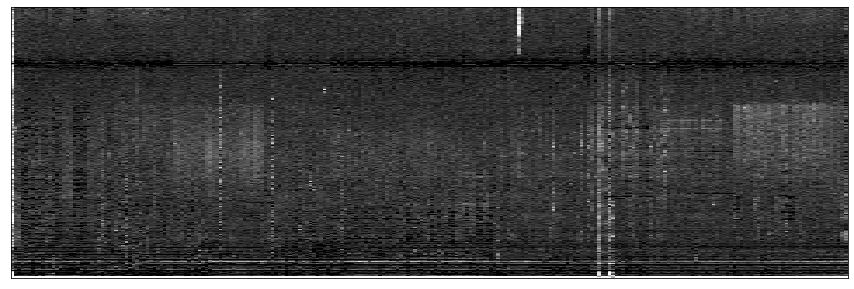

In [18]:
plt.figure(figsize=(15, 5))
librosa.display.specshow(S[0, :, :], cmap='gray')


In [21]:
import os
os.listdir("/beegfs/vl1019/")

['Robin_Data',
 'BirdVox-full-season_bvd-v022-ca',
 'SWIFT_Oct3-8.zip',
 'BirdVoxDetect-v03_data',
 'synopsis_seriation_data',
 'spl2018_datasets',
 'SWIFT_Oct3-8',
 'BirdVox-full-season_bvd-v023-ca',
 'bvd020a_test',
 'BirdVox-full-season_bvd-v021-ca',
 'TinySOL2020_release',
 'BirdVox-full-season_bvd-v023-ca_randomized-counts',
 'bulbul_data',
 'BirdVox-full-season_data',
 'BirdVox-tofu-training']

/home/vl1019/birdvoxpaint/birdvoxpaint/display.py:85: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


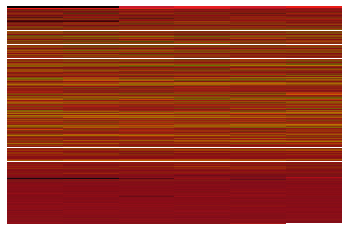

In [13]:
import librosa
import numpy as np

S = S_raw*1 + 0
S[0, :, :] = (S[0, :, :]-2/3) * 2
S[1, :, :] = (S[1, :, :]-0.05) * 5
S[2, :, :] = (S[2, :, :]-0.2) * 3
S = np.clip(S, 0, 1)

sr = librosa.get_samplerate(filename)
bvp.display.specshow(
    np.transpose(S_raw, (2, 1, 0)),
    sr=sr, normalize=True
)

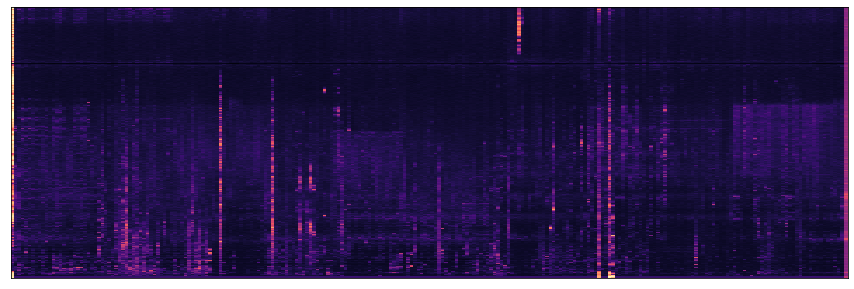

In [9]:
import librosa.display
plt.figure(figsize=(15, 5))
librosa.display.specshow(S_raw[1, :, :])

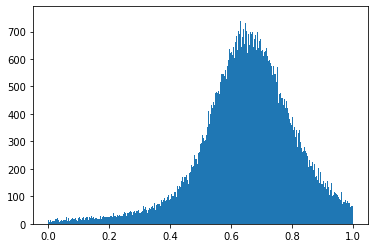

In [12]:
import numpy as np
import matplotlib
%matplotlib inline
from matplotlib import pyplot as plt

plt.hist(np.ravel(S_raw[0, :, :]-0.6)*4, bins=np.linspace(0, 1, 1000));

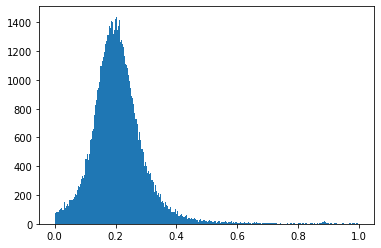

In [22]:
S = S_raw*1 + 0
S[0, :, :] = (S[0, :, :]-2/3) * 2
S[1, :, :] = (S[1, :, :]-0.05) * 5

plt.hist(np.ravel(S[0, :, :]), bins=np.linspace(0, 1, 1000));

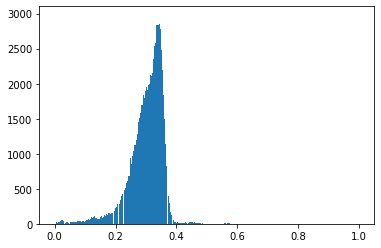

In [4]:
plt.hist(np.ravel(S[2, :, :]), bins=np.linspace(0, 1, 1000));

Text(0.5, 0, 'Time (hh:mm:ss)')

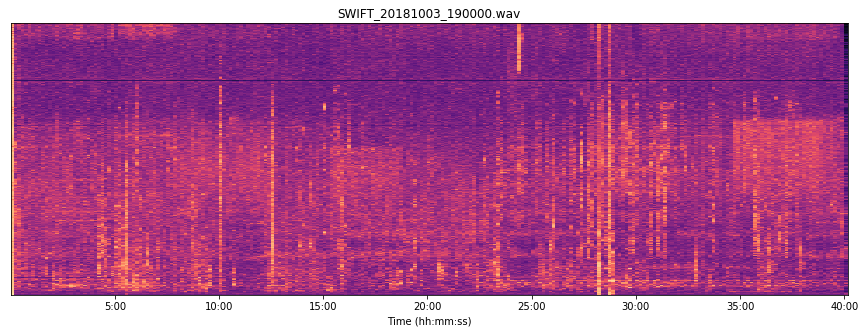

In [3]:
import librosa
from librosa.display import specshow
import numpy as np
import os
import soundfile as sf

segment_duration=10

sr = librosa.get_samplerate(filename)
segment_length = segment_duration*sr
total_duration = len(sf.SoundFile(filename)) / sr
tick_duration = 5 * 60
xticks = np.arange(tick_duration, total_duration, tick_duration)

plt.figure(figsize=(15, 5))
specshow(S[0, :, :], x_axis='time', sr=sr, hop_length=segment_length)
plt.xticks(xticks)
plt.title(os.path.split(filename)[1]);
plt.xlabel("Time (hh:mm:ss)")

In [5]:
S_rgb = bvp.transform(filename=filename,
              frame_length=2048, hop_length=512,
              n_mels=None, fmin=None, fmax=None,
              indices=[bvp.indices.towsey_rgb],
              segment_duration=10,
              verbose=True, n_jobs=None)

AttributeError: module 'birdvoxpaint.indices' has no attribute 'towsey_rgb'

In [14]:
joblib.cpu_count()

1

In [2]:
# if n_jobs is None or -1, parallelize across all available CPUs
if not n_jobs or n_jobs < 0:
    n_jobs = joblib.cpu_count()

# measure sample rate and segment length
sr = sf.SoundFile(filename).samplerate
segment_length = segment_duration * sr
n_frames_per_segment = int(segment_length/frame_length)

# adjust segment_duration so that it matches the unit roundoff
# of the Euclidean division above
segment_duration = n_frames_per_segment * frame_length

# create a librosa generator object to loop through blocks
librosa_generator = librosa.core.stream(
    filename, n_frames_per_segment, frame_length, hop_length)

# measure duration of the recording
total_duration = librosa.get_duration(filename=filename)
n_segments = int(total_duration / segment_duration)

# contruct tqdm generator from librosa generator
# this allows to display a progress bar
tqdm_generator = tqdm.tqdm(librosa_generator, total=n_segments, disable=not verbose)

# define frequency slicing function
# this function reduces the STFT or melspectrogram to a
# specific subband [fmin, fmax], measured in Hertz.
slice_fun = util.freq_slice(fmin, fmax, sr, frame_length)

# define spectrogram function.
spec_fun = partial(spec,
    n_fft=frame_length, hop_length=hop_length,
    win_length=frame_length, n_mels=n_mels,
    sr=sr, fmin=fmin, fmax=fmax,
     _fft_slice=slice_fun)

# define a closure for computing acoustic indices of a segment y.
indices_fun = lambda y: [np.stack(
    [acoustic_index(S) for acoustic_index in indices], axis=-1)
    for S in [spec_fun(y)]][0]

# delay execution of the closure above
delayed_indices_fun = joblib.delayed(indices_fun)

# construct joblib generator from delayed joblib object.
joblib_generator = (delayed_indices_fun(y) for y in tqdm_generator)

# construct joblib Parallel object.
parallel_fun = joblib.Parallel(n_jobs=n_jobs)

# execute
S = np.stack(parallel_fun(joblib_generator))


962it [00:06, 139.19it/s]


In [18]:
S.shape

(3, 1025)

In [4]:
total_duration

2400.2555208333333

400.0

In [30]:
# get blocks from file
orig_sr = librosa.get_samplerate(filename)
sr = sr or orig_sr

# see: https://librosa.github.io/librosa/_modules/librosa/core/audio.html#stream
# block_length is in units of `frames` so reverse calculation
block_length = max(segment_duration * orig_sr, frame_length) * n_blocks
block_n_frames = librosa.core.samples_to_frames(
    block_length, hop_length)
block_length = librosa.core.frames_to_samples(
    block_n_frames, hop_length)

<generator object stream at 0x2b275504d150>